# Example of PSF Fitting and Aperture Photometry Using Mock Data

## PSF fitting

### Step 1: Prepare Mock Input Data for PSF Fitting

Import the required objects for creating mock input data to demonstrate PSF fitting.

In [1]:
from matplotlib import pyplot
import numpy
from ctypes import c_ubyte, c_char
from os.path import expanduser

from astrowisp.fake_image.piecewise_bicubic_psf import PiecewiseBicubicPSF
from astrowisp.tests.test_fit_star_shape.utils import make_image_and_source_list

Create a mock image, sub-pixel map and list of sources to demonstrate PSF fitting.

The properties of the created items are:

  * The image contains a single source with center at (5, 5).

  * The PSF is on a bicubic grid with x boundaries -2, 0 and 2 and y boundaries -1, 0, 1 relative to the center.
  
  * The PSF, its first order derivatives and the x-y cross derivative are all zero at the boundaries
    $$x=\pm2 \quad\mathrm{or}\quad y=\pm1$$
    
  * The first order derivative and the x-y cross derivative are zero at the center (x=0, y=0) and the values is 1 ADU.
  
  * The image has a background of 1 ADU
  
  * The source list contains exactly the following columns: `ID`, `x` and `y` giving a unique Id for the source and 
    the position of its center in the image
    
  * The sub-pixel map is a good approximation for the effective sensitivity map that should be used for DSLR cameras, 
    which stagger 4 channels on the image, and hence only a quarter of each "pixel" is sensitive for each channel

Source list:array([(b'000000', 5., 5.)],
      dtype=[('ID', 'S6'), ('x', '<f8'), ('y', '<f8')])


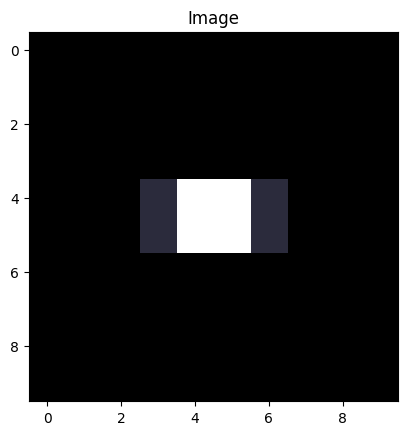

In [2]:
subpix_map = numpy.zeros(shape=(4,4), dtype=float)
subpix_map[1:3,1:3] = 4.0

values = numpy.zeros((3, 3))
d_dx = numpy.zeros((3, 3))
d_dy = numpy.zeros((3, 3))
d2_dxdy = numpy.zeros((3, 3))
values[1, 1] = 1.0
        
sources = [
    dict(
        x=5.0,
        y=5.0,
        psf=PiecewiseBicubicPSF(
            psf_parameters=dict(
                values=values,
                d_dx=d_dx,
                d_dy=d_dy,
                d2_dxdy=d2_dxdy
            ),
            boundaries=dict(x=numpy.array([-2.0, 0.0, 2.0]),
                            y=numpy.array([-1.0, 0.0, 1.0]))
        )
    )
]

image, source_list = make_image_and_source_list(sources, subpix_map=subpix_map)
pyplot.imshow(image, cmap=pyplot.cm.bone)
pyplot.title('Image')
print('Source list:' + repr(source_list))

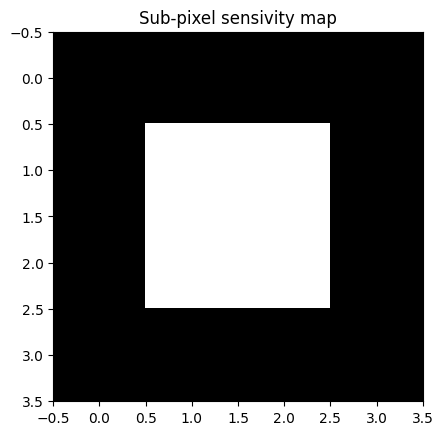

In [3]:
pyplot.imshow(subpix_map, cmap=pyplot.cm.bone)
pyplot.title('Sub-pixel sensivity map');

### Step 2: Perform the PSF Fitting

Import the required objects for PSF fitting and Background extraction

In [4]:
from astrowisp import FitStarShape, BackgroundExtractor

Construct a PSF fitting object

In [5]:
fit_star_shape = FitStarShape(
    mode='PSF', # use PSF fitting (as opposed to PRF)
    grid=[numpy.array([-2.0, 0.0, 2.0]),
          numpy.array([-1.0, 0.0, 1.0])], # Use the same grid that was used to create the sources
    initial_aperture=3.0, # Initial guess for source flux will be measured using an aperture with radius 3 pixels
    subpixmap=subpix_map, # Assume the same sub-pixel map that was used to generate the image
    max_abs_amplitude_change=0.0, # Force convergence based entirely on relative change in the amplitudes
    max_rel_amplitude_change=1e-6, # Require that the flux estimates change by no more than ppm for convergence
    bg_min_pix=3 #Require that the background is determined using at least 3 pixels
)

Measure the background behind the sources.

In [6]:
background = BackgroundExtractor(
    image,
    3, # Include only pixels with centers at least 3 pixels away from the source center.
    6  # Include only pixels with centers at most 6 pixels away from the source center.
)
background(
    numpy.array([5.0]), # list of source x coordinates
    numpy.array([5.0])  # list of source y coordinates
);

Define terms on which the PSF shape parameters are allowed to depend linearly. These can be things like ``x`` or ``x^2y``. The shape should be ``(<number of sources>, <number of terms>)``. In this case we wish to fit non-variable PSF since there is only one star in the image.

In [7]:
psf_terms = numpy.ones((source_list.size, 1))

Find the best-fit PSF shape.

In [8]:
result_tree = fit_star_shape.fit(
    [
        (
            image, # The pixel values in the image
            image**0.5, # Standard deviations of the pixels values (assume Poisson noise only and gain of 1)
            numpy.zeros(image.shape, dtype=c_ubyte),
            source_list,
            psf_terms
        )
    ],
    [background]
)

### Results

Let's look at the coefficients of the polynomial expansion of the PSF parameters. In our case, the PSF has 4 free parameters $f$, $\frac{\partial f}{\partial x}$, $\frac{\partial f}{\partial y}$, and $\frac{\partial^2 f}{\partial x\partial y}$ at the center of the grid (all other grid intersections lie on the boundary and hence are contsrained to be zero.

The PSF we used to create the source had: $f = 1$, and $\frac{\partial f}{\partial x} = \frac{\partial f}{\partial y} = \frac{\partial^2 f}{\partial x\partial y} = 0$, which we expect to recover.

In [9]:
print('PSF map coefficients: '
      +
      repr(result_tree.get('psffit.psfmap', shape=(4,))))

PSF map coefficients: array([ 5.00000000e-01,  5.55111512e-17,  2.77555756e-17, -6.40535904e-16])


The coefficients are half of the values we used to recover, because the PSF shape has been normalized to have a flux of exactly 1. The product of the flux with the coefficients should give us the values we used at construction:

In [10]:
print('PSF fit flux: '
      +
      repr(result_tree.get('psffit.flux.0', shape=(len(sources),))))

PSF fit flux: array([2.])


## Aperture Photometry

Import the aperture photometry object

In [11]:
from astrowisp import SubPixPhot

Construct an aperture photometry object to use the assumed sub-pixel sensitivity map, and three apertures. All other configuration options are left at their default values.

In [12]:
do_apphot = SubPixPhot(subpixmap=subpix_map,
                       apertures=[1.0, 2.0, 3.0])

Measure the fluxes usinge the specified configuration, assuming the input image follows poisson statistics and a clean bad pixel mask.

In [13]:
do_apphot(
    (
        image, # The measured response of the image pixels
        image**0.5, # Standard deviation estimate for the
                # response of image pixels (assume
                # Poission statistics)
        numpy.zeros(image.shape, dtype=c_char), # Bad pixel mask: all zeros means all pixels are clean.
    ),
    result_tree, # Result object, must contain PSF
                 # fitting results already and is
                 #updated with aperture photometry
)

Setting apertures
Reading PSF map
Reading model
Reading grid
Reading coefficients
Creating flux measuring object
Measuring flux for image 0
tree suffix = .0
Reading background


### Results

The first two apertures are not large enough to encompass the entire source, so we expect the flux to be underestimated, by a lot and then by a little, and the last aperture should recover the exact source flux.

In [14]:
apertures = do_apphot.configuration['apertures']
magnitudes = numpy.array([
    result_tree.get('apphot.mag.0.' + str(ap_ind), shape=(1,))
    for ap_ind in range(len(apertures))
])
magnitude_errors = numpy.array([
    result_tree.get('apphot.mag_err.0.' + str(ap_ind), shape=(1,))
    for ap_ind in range(len(apertures))
])
fluxes = 10.0**((do_apphot.configuration['magnitude_1adu'] - magnitudes)/2.5)

print('%-10.10s %10.10s +- %-10.10s %-10.10s'
      %
      ('Aperture', 'Magnitude', 'Error', 'Flux'))
line_fmt = '%-10.5g %10.5g +- %-10.5g %-10.5g'
for source_info in zip(apertures,
                       magnitudes,
                       magnitude_errors,
                       fluxes):
    print(line_fmt % source_info)

Aperture    Magnitude +- Error      Flux      
1               9.531 +- nan        1.5403    
2              9.2475 +- nan        1.9998    
3              9.2474 +- nan        2         
